# Mini project

A regression problem of predicting `reviews_per_month`, as a proxy for the popularity of the listing with [New York City Airbnb listings from 2019 dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data).

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 1. Understand the dataset

**Tasks:**

1. Understanding the problem and what each feature means. 
2. Download the dataset and read it as a pandas dataframe. 
3. Carry out any preliminary preprocessing, if needed.
    
</div>


I will start by doing EDA on the dataset and set up a column transformer to preprocess the data, then I will split the data into train and test datasets, and calculate cross validation scores for the potential models on the train set. Lastly, I will report scores with the models and choose the model based on CV scores and scoring metrics.

In [1]:
import pandas as pd
import numpy as np
import altair_ally as aly
import altair as alt
import warnings
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_validate)
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression, 
    Ridge, 
    RidgeCV, 
    LassoCV)
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor)
from scipy.stats import loguniform, randint
from sklearn.model_selection import RandomizedSearchCV
import shap


warnings.filterwarnings('ignore', category=FutureWarning)
aly.alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

In [2]:
#start code to read the data 
#transform last_review from object format to datetime format
NY_airbnb = pd.read_csv('data/AB_NYC_2019.csv')

NY_airbnb = NY_airbnb.dropna()

NY_airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 2. Data splitting <a name="2"></a>


**Tasks:**

1. Split the data into train and test portions.
    
</div>

In [3]:
train_df, test_df = train_test_split(NY_airbnb, test_size=0.35, random_state=123)
X_train, y_train = train_df.drop(columns=["reviews_per_month"]), train_df["reviews_per_month"]
X_test, y_test = test_df.drop(columns=["reviews_per_month"]), test_df["reviews_per_month"]
train_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
44893,34453822,Quiet Room Next to Times Square and Bryant Park,260191397,Hotel Mela,Manhattan,Theater District,40.75745,-73.98596,Private room,100,1,7,2019-06-17,4.04,7,296
25676,20558461,"Big Private Room in shared apt in Rego Park, NY",146823994,Abdul,Queens,Rego Park,40.73086,-73.85663,Private room,44,2,12,2019-01-01,0.53,1,0
44071,34020040,"Homey, Friendly Apt Share Next To Subway",253836845,Ollie,Brooklyn,Crown Heights,40.67058,-73.95730,Private room,68,30,1,2019-05-21,0.60,7,226
31084,24122599,Cozy room in a Victorian house in Central Broo...,14905006,Myriam,Brooklyn,Kensington,40.63966,-73.97160,Private room,52,1,11,2019-05-27,0.81,1,0
16991,13506168,Spacious Beautiful 1 bdrm in Gramercy,25912717,Will,Manhattan,Gramercy,40.73813,-73.98213,Entire home/apt,175,2,1,2016-06-26,0.03,1,0


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 3. EDA <a name="3"></a>
Perform exploratory data analysis on the train set.

**Tasks:**

1. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
2. Summarize your initial observations about the data. 
3. Pick appropriate metric/metrics for assessment. 
    
</div>

Summary of initial observation:

- Numeric features vary widely in scale (e.g., latitude: 40.728990–40.913060, price and number_of_reviews: 0–10,000), highlighting the need for scaling. 

- Features like id, host_name, and host_id should be dropped due to their uniqueness and low predictive value. 

- Correlation analysis shows weak relationships between numeric features and the target variable (reviews_per_month), with all correlations falling between -0.25 and 0.25.

In [4]:
#perform EDA using describe() and info()
train_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,2.523300e+04,2.523300e+04,25233.000000,25233.000000,25233.000000,25233.000000,25233.000000,25233.000000,25233.000000,25233.000000
mean,1.798131e+07,6.334293e+07,40.728331,-73.951309,142.506123,5.945983,29.379226,1.365231,5.104347,114.240558
std,1.070396e+07,7.535072e+07,0.055107,0.046597,199.325460,18.593411,48.430017,1.665430,25.985433,129.439908
min,2.539000e+03,2.438000e+03,40.506410,-74.244420,0.000000,1.000000,1.000000,0.010000,1.000000,0.000000
25%,8.589668e+06,6.828085e+06,40.688720,-73.982340,69.000000,1.000000,3.000000,0.190000,1.000000,0.000000
50%,1.871953e+07,2.784779e+07,40.721680,-73.955050,100.000000,2.000000,9.000000,0.710000,1.000000,54.000000
75%,2.746639e+07,9.869714e+07,40.763150,-73.935670,170.000000,4.000000,34.000000,2.000000,2.000000,228.000000
max,3.645581e+07,2.738417e+08,40.913060,-73.719280,10000.000000,1250.000000,629.000000,27.950000,327.000000,365.000000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25233 entries, 44893 to 18958
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              25233 non-null  int64  
 1   name                            25233 non-null  object 
 2   host_id                         25233 non-null  int64  
 3   host_name                       25233 non-null  object 
 4   neighbourhood_group             25233 non-null  object 
 5   neighbourhood                   25233 non-null  object 
 6   latitude                        25233 non-null  float64
 7   longitude                       25233 non-null  float64
 8   room_type                       25233 non-null  object 
 9   price                           25233 non-null  int64  
 10  minimum_nights                  25233 non-null  int64  
 11  number_of_reviews               25233 non-null  int64  
 12  last_review                     2

In [6]:
#numeric and categorical features that need to be dropped because of their uniqueness.
print(train_df['id'].nunique())
print(train_df['host_id'].nunique())
print(train_df['host_name'].nunique())

25233
20782
7595


In [7]:
#produce visualizations on categorical features: neighbourhood_group, neighbourhood and room_type

#bar plot for neighbourhood_group
bar_neigh_group = alt.Chart(train_df).mark_bar().encode(
    x = 'count()',
    y = alt.Y('neighbourhood_group').sort('-x'),
)

#bar_plot for room_type
bar_room_type = alt.Chart(train_df).mark_bar().encode(
    x = 'count()',
    y = alt.Y('room_type').sort('-x'),
)

#get unique values of neighbourhood
uni_value_count_neighbourhood = train_df['neighbourhood'].value_counts()

print(uni_value_count_neighbourhood)

neighbourhood
Williamsburg          2092
Bedford-Stuyvesant    2012
Harlem                1453
Bushwick              1257
Upper West Side        994
                      ... 
West Farms               1
Holliswood               1
Breezy Point             1
Eltingville              1
Richmondtown             1
Name: count, Length: 214, dtype: int64


In [8]:
bar_neigh_group

alt.Chart(...)

In [9]:
bar_room_type

alt.Chart(...)

In [10]:
#checking numeric features' correlations except for id and host_id
numeric_features = ['latitude',
                    'longitude',	
                    'price',	
                    'minimum_nights',	
                    'number_of_reviews',
                    'calculated_host_listings_count',
                    'availability_365']

correlation_matrix = train_df[numeric_features].corr()
correlation_long = correlation_matrix.reset_index().melt(id_vars='index')
correlation_long.columns = ['Feature 1', 'Feature 2', 'Correlation']

alt.Chart(correlation_long, width=80, height=80).mark_rect().encode(
    x='Feature 1:O',
    y='Feature 2:O',
    color=alt.Color('Correlation:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=['Feature 1', 'Feature 2', 'Correlation']
).properties(
    width=600,
    height=600,
    title="Correlation Heatmap"
)

alt.Chart(...)

In [11]:
aly.corr(train_df)

alt.ConcatChart(...)

In [12]:
#to check the range of correlations 
alt.Chart(correlation_long).mark_bar().encode(
    x = 'Correlation',
    y = 'count()')


alt.Chart(...)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 4. Preprocessing and transformations <a name="5"></a>
**Tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 
    
</div>

In [14]:
drop_features = ['id',
                 'host_id',
                 'host_name']

categorical_features = ['neighbourhood_group',
                        'neighbourhood',
                        'room_type',
                        'last_review']
text_features = 'name'


In [15]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value = -1), categorical_features),
    (CountVectorizer(stop_words="english"), text_features),
    ("drop", drop_features)
)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 5. Baseline model <a name="6"></a>
**Tasks:**
1. Train a baseline model for your task and report its performance.
    
</div>

In [16]:
# find the mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results = {}

#try DummyRegressor model and get CV results
dummy = DummyRegressor() 

cross_val_results['dummy'] = pd.DataFrame(
        cross_validate(
        dummy,
        X_train,
        y_train,
        return_train_score=True
    )
).agg(['mean', 'std']).round(5).T

#show mean and std of CV results of DummyRegressor model
cross_val_results['dummy']

,mean,std
fit_time,0.00123,0.00050
score_time,0.00022,0.00005
test_score,-0.00027,0.00035
train_score,0.00000,0.00000


In [17]:
#fit the model
dummy.fit(X_train, y_train)

#report train score
train_score_dummy = dummy.score(X_train, y_train)
train_score_dummy

0.0

In [18]:
#report test score
test_score_dummy = dummy.score(X_test, y_test)
test_score_dummy

-0.00017907409091266757

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 6. Linear models <a name="7"></a>

**Tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the regularization hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize the results.
    
</div>

Summary:
- From the CV results below, we can see that both mean test(0.43732) and mean train (0.45279) scores are low, thus this Ridge model underfits the data, which implies that the model doesn't capture the underlying patterns in the data well.
- The mean of fit time is very long, which implies high computational overhead. 
- The number of non-zero coefficients is 5385, most of them are originated from Countvectorizer. A large number of redundant coefficients can also increase computational complexity and memory usage without improving model performance.
- The test score is 0.4130877019657089, the train score is 0.45061872757465393, also indicates the model is underfitting the dataset.
- Thus, the model doesn't fit the data well and further improvement is needed.

In [19]:
#try a linear model with Ridge and tune alpha
alphas = 10.0 ** np.arange(-5, 5, 1)

ridge = make_pipeline(preprocessor, RidgeCV(alphas=alphas, cv=5))

In [20]:
#get CV results dataframe for Ridge
cross_val_results['ridge'] = pd.DataFrame(
        cross_validate(
        ridge,
        X_train,
        y_train,
        cv = 5,
        return_train_score=True
    )
).agg(['mean', 'std']).round(5).T

#show mean and std of CV results of Ridge model
cross_val_results['ridge']

,mean,std
fit_time,0.64147,0.02661
score_time,0.02053,0.00027
test_score,0.43732,0.01254
train_score,0.45279,0.00298


In [21]:
# fit the model
ridge.fit(X_train, y_train)

#find the best alpha
ridge_alpha = ridge.named_steps['ridgecv'].alpha_

ridge_alpha

np.float64(100.0)

In [22]:
# create a dataframe of the coeffcients
ridge_coef = ridge[:-1].get_feature_names_out()

ridge_coef_df = pd.DataFrame({
    'variable': ridge_coef,
    'coef': ridge.named_steps['ridgecv'].coef_.tolist()
})

ridge_coef_df

,variable,coef
0,standardscaler__latitude,-0.048306
1,standardscaler__longitude,0.114205
2,standardscaler__price,-0.004776
3,standardscaler__minimum_nights,-0.091987
4,standardscaler__number_of_reviews,0.751964
...,...,...
5380,countvectorizer__한성,0.005002
5381,countvectorizer__ｱｸｾｽ抜群,-0.001535
5382,countvectorizer__ｳｨﾘｱﾑｽﾞﾊﾞｰｸﾞのかわいいお部屋です2,-0.000962
5383,countvectorizer__ﾏﾝﾊｯﾀﾝ10分,-0.001535


In [23]:
#count non-zero coefficients
n_coefs_nonzero_ridge = ((ridge.named_steps['ridgecv'].coef_) != 0).sum()
n_coefs_nonzero_ridge

np.int64(5385)

In [24]:
# report the train score
train_score_ridge = ridge.score(X_train, y_train)
train_score_ridge

0.45061872757465393

In [25]:
# report the test score
test_score_ridge = ridge.score(X_test, y_test)
test_score_ridge

0.4130877019657089

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 7. Different models <a name="8"></a>
**Tasks:**
1. Try out three other models aside from the linear model. 
2. Summarize the results in terms of overfitting/underfitting and fit and score times. 
3. Can you beat the performance of the linear model? 
    
</div>

Answer:
I also used Lasso model, RandomForestRegressor model and GardientBoostingRegressor model. 

Comparison between above three model and the linear model (Ridge model):
- Lasso:
  - has the longest mean fit time
  - CV results: mean train score is 0.45080, mean test score is 0.43700
  - train score is 0.4478163165767438, test score is 0.41333833995252334
    
- RandomForestRegressor:
  - has the second longest mean fit time
  - CV results: mean train score is 0.95026, mean test score is 0.65634	
  - train score is 0.9513277342209916, test score is 0.6307274904682476
    
- GardientBoostingRegressor:
  - has the third longest mean fit time
  - CV results: mean train score is 0.65467, mean test score is 0.63095
  - train score is 0.6525094855132751, test score is 0.6034722669200422

- Linear (Ridge):
  - has the shortest fit time
  - CV results: mean train score is 0.45279, mean test score is 0.43732
  - train score is 0.45061872757465393, test score is 0.4130877019657089


From above results, GradientBoostingRegressor model performs better than the other three models overall.  

As the GradientBoostingRegressor model has the highest train and test score, and lower mean fit time and mean score time. Even though, both of the mean train score and mean test score are relatively low, around 0.6, overall, it has the best performance.

First model: Lasso

In [26]:
#try lasso model

# setup the pipeline
alphas = 10.0 ** np.arange(-3, 3, 1)
lasso = make_pipeline(preprocessor, LassoCV(alphas=alphas, max_iter=3_000, tol=0.01, random_state = 123))

In [27]:
cross_val_results['lasso'] = pd.DataFrame(
        cross_validate(
        lasso,
        X_train,
        y_train,
        cv = 5,
        return_train_score=True
    )
).agg(['mean', 'std']).round(5).T

#show mean and std of CV results of Lasso model
cross_val_results['lasso']

,mean,std
fit_time,27.70361,10.36554
score_time,0.03188,0.01157
test_score,0.43700,0.01272
train_score,0.45080,0.00325


In [28]:
# fit the lasso model
lasso.fit(X_train, y_train)

#find the best alpha
lasso_alpha = lasso.named_steps['lassocv'].alpha_

lasso_alpha

np.float64(0.001)

In [29]:
# create a dataframe of the lasso coeffcients
lasso_coef = lasso[:-1].get_feature_names_out()

lasso_coef_df = pd.DataFrame({
    'variable': lasso_coef,
    'coef': lasso.named_steps['lassocv'].coef_.tolist()
})

lasso_coef_df

,variable,coef
0,standardscaler__latitude,-0.027210
1,standardscaler__longitude,0.106793
2,standardscaler__price,0.010259
3,standardscaler__minimum_nights,-0.099051
4,standardscaler__number_of_reviews,0.748722
...,...,...
5380,countvectorizer__한성,0.000000
5381,countvectorizer__ｱｸｾｽ抜群,-0.000000
5382,countvectorizer__ｳｨﾘｱﾑｽﾞﾊﾞｰｸﾞのかわいいお部屋です2,-0.000000
5383,countvectorizer__ﾏﾝﾊｯﾀﾝ10分,-0.000000


In [30]:
#report train score
train_score_lasso = lasso.score(X_train, y_train)
train_score_lasso

0.4478163165767438

In [31]:
#report test score
test_score_lasso = lasso.score(X_test, y_test)
test_score_lasso

0.41333833995252334

Second model: RandomForestRegressor

In [32]:
rf = make_pipeline(
    preprocessor,
    RandomForestRegressor(
        n_jobs=-1,
        n_estimators=50,
        random_state=123))


In [33]:
cross_val_results['rfregressor'] = pd.DataFrame(
        cross_validate(
        rf,
        X_train,
        y_train,
        cv = 5,
        return_train_score=True
    )
).agg(['mean', 'std']).round(5).T

#show mean and std of CV results of Lasso model
cross_val_results['rfregressor']

,mean,std
fit_time,8.08882,0.10491
score_time,0.04082,0.00626
test_score,0.65634,0.01141
train_score,0.95026,0.00029


In [34]:
# fit the RandomForestRegressor model
rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['latitude', 'longitude',
                                                   'price', 'minimum_nights',
                                                   'number_of_reviews',
                                                   'calculated_host_listings_count',
                                                   'availability_365']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['neighbourhood_group',
                                                   'neighbourhood', 'room_type',
                                                   'last_review']),
                                                 ('countvectorizer',
                                                  CountVectorizer(stop_words='english'),
                                                  'name'),
                                                 ('drop', 'drop',
                                                  ['id', 'host_id',
                                                   'host_name'])])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=50, n_jobs=-1,
                                       random_state=123))])

In [35]:
#report train score
train_score_rf = rf.score(X_train, y_train)
train_score_rf

0.9513277342209916

In [36]:
#report test score
test_score_rf = rf.score(X_test, y_test)
test_score_rf

0.6307274904682476

Third model: GardientBoostingRegressor

In [37]:
gb = make_pipeline(
    preprocessor,
    GradientBoostingRegressor(
        n_estimators=50,
        random_state=123))

cross_val_results['gbregressor'] = pd.DataFrame(
        cross_validate(
        gb,
        X_train,
        y_train,
        cv = 5,
        return_train_score=True
    )
).agg(['mean', 'std']).round(5).T

#show mean and std of CV results of Lasso model
cross_val_results['gbregressor']

,mean,std
fit_time,1.61123,0.01108
score_time,0.02344,0.00096
test_score,0.63095,0.01180
train_score,0.65467,0.00296


In [38]:
# fit the GradientBoostingRegressor model
gb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['latitude', 'longitude',
                                                   'price', 'minimum_nights',
                                                   'number_of_reviews',
                                                   'calculated_host_listings_count',
                                                   'availability_365']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['neighbourhood_group',
                                                   'neighbourhood', 'room_type',
                                                   'last_review']),
                                                 ('countvectorizer',
                                                  CountVectorizer(stop_words='english'),
                                                  'name'),
                                                 ('drop', 'drop',
                                                  ['id', 'host_id',
                                                   'host_name'])])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(n_estimators=50, random_state=123))])

In [39]:
#report train score
train_score_gb = gb.score(X_train, y_train)
train_score_gb

0.6525094855132751

In [40]:
#report test score
test_score_gb = gb.score(X_test, y_test)
test_score_gb

0.6034722669200422

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 8. Hyperparameter optimization
**Tasks:**

1. Make some attempts to optimize hyperparameters for the models you've tried and summarize your results.
2. Briefly summarize your results.
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 
    
</div>

Summary:
- Based on below results, the best parameters of the RandomForestRegressor model is countvectorizer's max_features: 5106, Randomforestregressor's n_estimators: 100; the best parameters of the GradientBoostingRegressor's n_estimators: 100. 

- From the LassoCV in question 8, the best alpha is 0.001. 

To tune the RanomdForestRegressor model:

In [42]:
#start hyperparameter optimization 
len_vocab = len( 
    rf.named_steps["columntransformer"]
    .named_transformers_["countvectorizer"]
    .get_feature_names_out()
)

param_dist = { 
    "columntransformer__countvectorizer__max_features": randint(5_000, len_vocab),
    "randomforestregressor__n_estimators": np.arange(10, 110, step = 10)
}

random_search = RandomizedSearchCV(  
    rf,
    param_distributions=param_dist,
    n_iter=10,
    verbose=1,
    n_jobs=-1,
    random_state=123,
)


In [43]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['latitude',
                                                                                'longitude',
                                                                                'price',
                                                                                'minimum_nights',
                                                                                'number_of_reviews',
                                                                                'calculated_host_listings_count',
                                                                                'availability_365']),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['neighb...
                                             ('randomforestregressor',
                                              RandomForestRegressor(n_estimators=50,
                                                                    n_jobs=-1,
                                                                    random_state=123))]),
                   n_jobs=-1,
                   param_distributions={'columntransformer__countvectorizer__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15e84ee40>,
                                        'randomforestregressor__n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
                   random_state=123, verbose=1)

In [44]:
# best hyperparameters
best_parameters = random_search.best_params_ 
best_parameters

{'columntransformer__countvectorizer__max_features': 5106,
 'randomforestregressor__n_estimators': np.int64(100)}

To tune the GradientBoostingRegressor model:

In [45]:
#start hyperparameter optimization 
param_dist = { 
    "gradientboostingregressor__n_estimators": np.arange(10, 110, step = 10)
}

random_search = RandomizedSearchCV(  
    gb,
    param_distributions=param_dist,
    n_iter=10,
    verbose=1,
    n_jobs=-1,
    random_state=123,
)

In [46]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['latitude',
                                                                                'longitude',
                                                                                'price',
                                                                                'minimum_nights',
                                                                                'number_of_reviews',
                                                                                'calculated_host_listings_count',
                                                                                'availability_365']),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['neighb...
                                                                                'last_review']),
                                                                              ('countvectorizer',
                                                                               CountVectorizer(stop_words='english'),
                                                                               'name'),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['id',
                                                                                'host_id',
                                                                                'host_name'])])),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(n_estimators=50,
                                                                        random_state=123))]),
                   n_jobs=-1,
                   param_distributions={'gradientboostingregressor__n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
                   random_state=123, verbose=1)

In [47]:
# best hyperparameters
best_parameters = random_search.best_params_ 
best_parameters

{'gradientboostingregressor__n_estimators': np.int64(100)}

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 9. Interpretation and feature importances <a name="1"></a>
**Tasks:**

1. Examine the most important features of one of the non-linear models. 
2. Summarize the observations. 
    
</div>

I will examine feature importance of GradientBoostingRegressor.

From below gb_imp_df, we can see that globally, feature 'number_of_reviews' has the highest importance value (0.570242) and thus has the most influential feature. The second most influential feature is minimum_nights, the third most influential feature is availability_365. 

In [48]:
#extract feature names
feature_names = gb[:-1].get_feature_names_out()

In [49]:
#extract feature importance
data = {
    "Importance": gb.named_steps["gradientboostingregressor"].feature_importances_,
}

In [50]:
#get the dataframe
gb_imp_df = pd.DataFrame(
    data=data,
    index=feature_names,
).sort_values(by="Importance", ascending=False)

gb_imp_df[:15]

,Importance
ordinalencoder__last_review,0.609370
standardscaler__number_of_reviews,0.231849
standardscaler__minimum_nights,0.100696
standardscaler__longitude,0.022983
standardscaler__availability_365,0.006767
countvectorizer__jfk,0.006418
countvectorizer__lga,0.005610
countvectorizer__lou,0.005174
standardscaler__latitude,0.002237
countvectorizer__common,0.001122


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 10. Results on the test set <a name="12"></a>
**Tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain them with SHAP force plots.  
    
</div>

Summary:

- Based on question 8, my best performing model is the GradientBoostingRegressor.

- The test score is 0.6034722669200422. The CV results of my GradientBoostingRegressor model is: mean train score is 0.65467, mean test score is 0.63095. Thus, the test score agree with the validation scores, they are around 0.6, therefore, I trust my model to a great extend. 

- As a separate test dataset was used to evaluate the model, I think my optimization bias is likely minimized.

- For the first SHAP force plot, we can see that 'last_review', 'minimum_nights' and 'number_of _reviews' are top 3 most influential features. 
For the second SHAP force plot, we can see that 'last_review', 'minimum_nights' and 'number_of _reviews' are also top 3 most influential features. One noticeable difference is that, in the first plot, 'last_review' has positive impact, it increases the prediction; in the second plot, 'last_review' has negative impact, it decreases the prediction. 

In [51]:
# report the test score
test_score_ridge = gb.score(X_test, y_test)
test_score_ridge

0.6034722669200422

In [52]:
X_train_enc = preprocessor.fit_transform(X_train).todense()

In [53]:
# We need access to the transformed features and their feature names
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.iloc[[0, 1]]

,standardscaler__latitude,standardscaler__longitude,standardscaler__price,standardscaler__minimum_nights,standardscaler__number_of_reviews,standardscaler__calculated_host_listings_count,standardscaler__availability_365,ordinalencoder__neighbourhood_group,ordinalencoder__neighbourhood,ordinalencoder__room_type,...,countvectorizer__숙소,countvectorizer__안전하고,countvectorizer__작은,countvectorizer__조용한,countvectorizer__주변,countvectorizer__한성,countvectorizer__ｱｸｾｽ抜群,countvectorizer__ｳｨﾘｱﾑｽﾞﾊﾞｰｸﾞのかわいいお部屋です2,countvectorizer__ﾏﾝﾊｯﾀﾝ10分,countvectorizer__ﾐｯﾄﾞﾀｳﾝｳｴｽﾄｻｲﾄﾞ
39615,0.653813,-0.782932,-0.112914,-0.266013,0.033467,-0.004016,1.597371,2.0,93.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19583,0.184534,-0.783576,0.469061,-0.266013,-0.131723,-0.157951,-0.882594,2.0,74.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
gb

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['latitude', 'longitude',
                                                   'price', 'minimum_nights',
                                                   'number_of_reviews',
                                                   'calculated_host_listings_count',
                                                   'availability_365']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['neighbourhood_group',
                                                   'neighbourhood', 'room_type',
                                                   'last_review']),
                                                 ('countvectorizer',
                                                  CountVectorizer(stop_words='english'),
                                                  'name'),
                                                 ('drop', 'drop',
                                                  ['id', 'host_id',
                                                   'host_name'])])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(n_estimators=50, random_state=123))])

In [55]:
gb_explainer = shap.TreeExplainer(
    gb.named_steps['gradientboostingregressor'],
    X_train_enc
)

gb_explanation = gb_explainer(X_test_enc)
gb_explanation[:2]

 95%|=================== | 12892/13588 [00:16<00:00]       

.values =
array([[ 0.00205964, -0.00787905, -0.00019984, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.01408305, -0.00016343, ...,  0.        ,
         0.        ,  0.        ]])

.base_values =
array([1.26234151, 1.26234151])

.data =
array([[ 0.65381303, -0.78293218, -0.11291367, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.18453411, -0.78357601,  0.46906065, ...,  0.        ,
         0.        ,  0.        ]])

In [56]:
# load JS visualization code to notebook
shap.initjs()

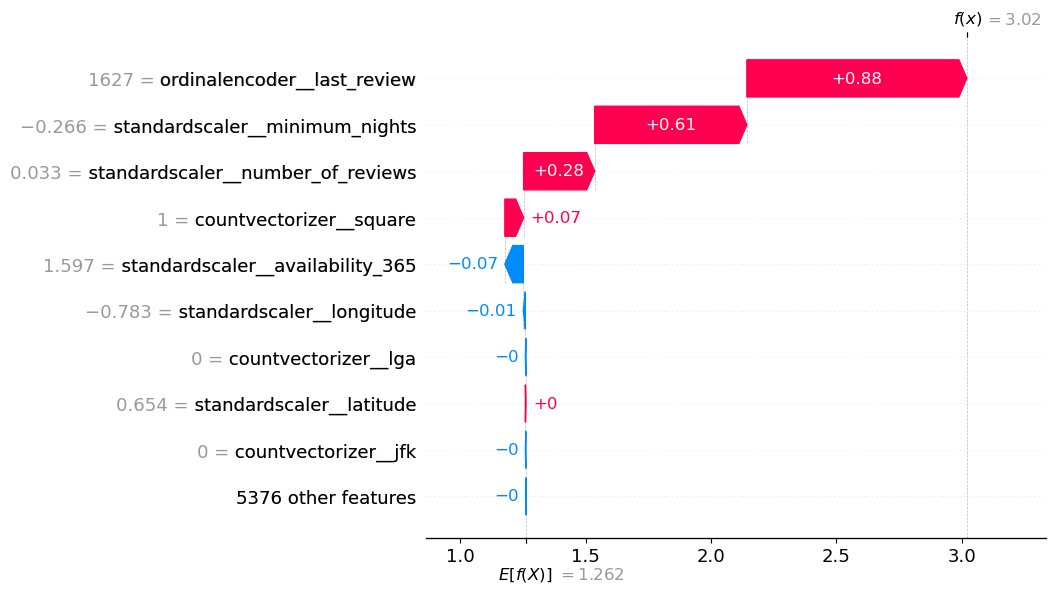

In [57]:
#first plot
shap.plots.waterfall(gb_explanation [0, :])

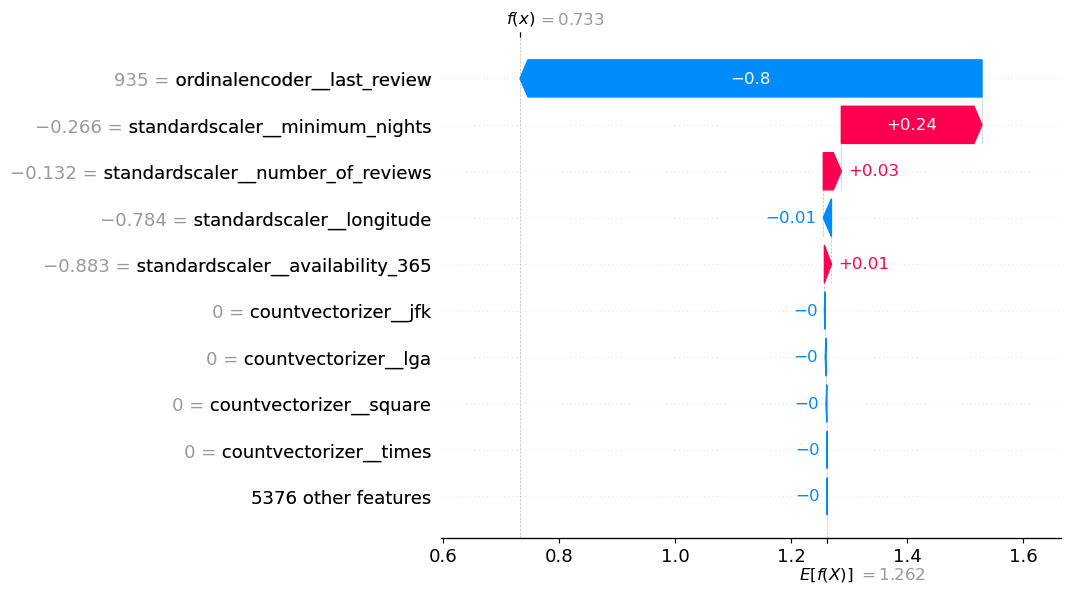

In [58]:
#second plot
shap.plots.waterfall(gb_explanation [1, :])

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 11. Summary of results <a name="13"></a>
**Tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook.
    
</div>

Summary:
- The GradientBoostingRegressor model outperformed the other models (DummyRegressor, RandomForestRegressor, Ridge, and Lasso) with the highest cross-validation (CV) mean train and test scores. Additionally, it demonstrated lower mean fit and score times, and its test score of 0.6035 aligns well with the CV results.

- Despite its superior performance, the CV results suggest that the GradientBoostingRegressor is underfitting the dataset. To address this, further improvement through feature engineering is recommended. This could involve creating new features that better represent the dataset and potentially improve both training and test scores.

In [59]:
#to show the table
pd.concat(
    cross_val_results,
    axis='columns'  # Get the right model names and mean/std as columns
)

dummy             ridge              lasso            \
                mean      std     mean      std      mean       std   
fit_time     0.00123  0.00050  0.64147  0.02661  27.70361  10.36554   
score_time   0.00022  0.00005  0.02053  0.00027   0.03188   0.01157   
test_score  -0.00027  0.00035  0.43732  0.01254   0.43700   0.01272   
train_score  0.00000  0.00000  0.45279  0.00298   0.45080   0.00325   

            rfregressor          gbregressor           
                   mean      std        mean      std  
fit_time        8.08882  0.10491     1.61123  0.01108  
score_time      0.04082  0.00626     0.02344  0.00096  
test_score      0.65634  0.01141     0.63095  0.01180  
train_score     0.95026  0.00029     0.65467  0.00296